#### iLQR for kinematic example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *

import pybullet as p
import pybullet_data

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

#### Setup pybullet with the urdf

In [2]:
# configure pybullet and load plane.urdf and quadcopter.urdf
#physicsClient = p.connect(p.DIRECT)  # pybullet only for computations no visualisation, faster
physicsClient = p.connect(p.GUI)  # pybullet with visualisation
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
p.resetSimulation()

robot_urdf = "../data/urdf/frankaemika_new/panda_arm.urdf"
robot_id = p.loadURDF(robot_urdf, useFixedBase=1)
joint_limits = get_joint_limits(robot_id, 7)

p.loadURDF('plane.urdf')

#Define the end-effector
link_id = 10
link_name = 'panda_grasptarget_hand'

#Create a ball to show the target
_,_,ballId = create_primitives(radius=0.05)

### Construct the robot system

In [4]:
dt = 0.05
T = 100
dof = 7
sys = URDFRobot(dof=dof, robot_id=robot_id, dt = dt)

#### Find a suitable target orientation

In [5]:
qT = np.random.uniform(-1,1,7)
qT[3] -= 1.5
qT[5] += 1.5
xT = np.concatenate([qT, np.zeros(7)])
sys.set_init_state(xT)
_,target_orn = sys.compute_ee(xT,link_id)
print("Target orientation: ",target_orn)

Target orientation:  [ 0.7645 -0.2788  0.1154  0.5697]


#### Set the initial state

In [6]:
q0 = np.random.rand(7)
q0 = np.array([0.,0.,0.,-1.5,0.,1.5,0.])
#q0 = np.array([0.4201, 0.4719, 0.9226, 0.8089, 0.3113, 0.7598, 0.364 ])
x0 = np.concatenate([q0, np.zeros(7)])
sys.set_init_state(x0)
_,x0_orn = sys.compute_ee(x0,link_id)
print("X0 orientation: ",x0_orn)

X0 orientation:  [ 0.9239  0.3827 -0.      0.    ]


#### Try forward kinematics

In [7]:
pos0, quat0 = sys.compute_ee(x0, link_id)

#Put the ball at the end-effector
p.resetBasePositionAndOrientation(ballId, pos0, quat0)
print(pos0)

[ 0.5477 -0.      0.5465]


#### Set initial control output

In [8]:
#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [9]:
Q = np.eye(sys.Dx)*1
Q[0:sys.dof,0:sys.dof] *= 0.01  #only put cost regularization on the velocity, not on the joint angles
Qf = np.eye(sys.Dx)*1
Qf[0:sys.dof,0:sys.dof] *= 0.01 #only put cost regularization on the velocity, not on the joint angles
R = np.eye(sys.Du)*1e-9
mu = 1e-9          #regularization coefficient

#### Set the task space cost coefficients W & WT

In [10]:
W = np.diag([1,1,1])
WT = np.diag([1,1,1])

### iLQR using cost model

#### Define the cost

In [11]:
#The costs consist of: a) state regularization (Q), b) control regularization (R), and c) End-effector reaching task (W)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
runningStateCost = CostModelQuadratic(sys, Q)
runningControlCost = CostModelQuadratic(sys, None, R)
runningEECost = CostModelQuadraticOrientation(sys,W, link_id,target_orn)
runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningEECost])

terminalStateCost = CostModelQuadratic(sys,Qf)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalEECost = CostModelQuadraticOrientation(sys,WT, link_id,target_orn)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalEECost])

costs = [runningCost]*T + [terminalCost]

#### Construct ILQR

In [12]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us) #set initial trajectory

In [13]:
ilqr_cost.mu = mu

#### Solve and Plot

In [14]:
n_iter = 30
ilqr_cost.solve(n_iter, method='recursive')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

#clear_output()

Cost converges at iteration 7, cannot decrease further


#### Play traj

In [15]:
sys.vis_traj(ilqr_cost.xs)

#### Compute Error

In [16]:
pos, quat = sys.compute_ee(ilqr_cost.xs[-1], link_id)

In [17]:
print(quat)

[ 0.7686 -0.2803  0.1186  0.5626]


In [18]:
print(target_orn)

[ 0.7645 -0.2788  0.1154  0.5697]


In [19]:
def plot_pose_matrix(ax,T,label=None,scale=1):
    base = T[:3,-1]
    orn = T[:3,:3]
    ax.plot([base[0],base[0]+scale*orn[0,0]],[base[1],base[1]+scale*orn[1,0]],[base[2],base[2]+scale*orn[2,0]],c='r')
    ax.plot([base[0],base[0]+scale*orn[0,1]],[base[1],base[1]+scale*orn[1,1]],[base[2],base[2]+scale*orn[2,1]],c='g')
    ax.plot([base[0],base[0]+scale*orn[0,2]],[base[1],base[1]+scale*orn[1,2]],[base[2],base[2]+scale*orn[2,2]],c='b')
    
    if label is not None:
        ax.text(base[0],base[1],base[2],label)

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [20]:
from scipy.spatial.transform import Rotation

desired_orn_mat = Rotation.from_quat( target_orn ).as_matrix()
obtained_orn_mat = Rotation.from_quat( quat ).as_matrix()

desired_frame = np.identity(4)
desired_frame[:3,:3] = desired_orn_mat

obtained_frame = np.identity(4)
obtained_frame[:3,:3] = obtained_orn_mat

<IPython.core.display.Javascript object>


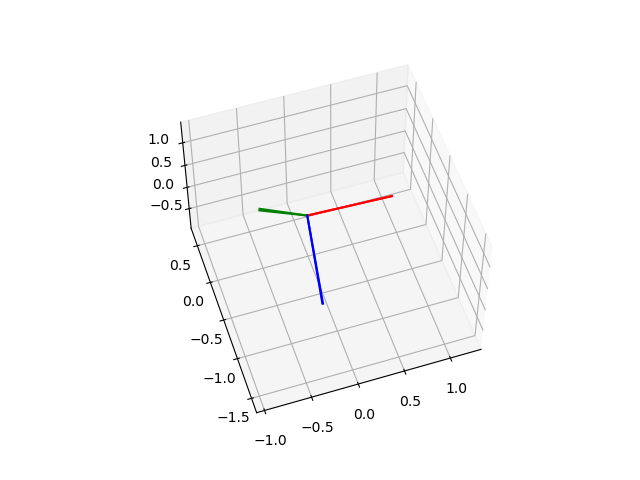

In [21]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_pose_matrix(ax,desired_frame,'')
plot_pose_matrix(ax,obtained_frame,'')
set_axes_equal(ax)
plt.show()